In [1]:
import pipeline as pipeline
print(pipeline.__file__)

/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/spline.py
/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/priors.py
/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/age_groups.py
/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/covariates.py
/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/likelihood.py
/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/pipeline.py


In [2]:
input_dir  = './input_data'
stage_dirs = ['amd_sim_data', 'amd_sim_data_Early', 'amd_sim_data_Intermediate', 'amd_sim_data_Late-dry', 'amd_sim_data_Late-wet']
stage      = stage_dirs[2] # Intermediate

pm_model = pipeline.initiliaze_pipeline(f'{input_dir}/{stage}', verbose=True)

number of rows: 207
number of unique location_id: 18
number of nodes: 233
number of edges: 232


In [3]:
rate_types = ['beta_binom', 'binom', 'neg_binom', 'poisson', 'log_normal', 'normal', 'offset_log_normal']
rate_type = rate_types[2]

pipeline.generate_pymc_objects(pm_model, rate_type=rate_type, include_covariates=True)

Standard errors replaced: 0
Effective sample sizes filled: 0


In [4]:
map_estimate = pipeline.return_map_estimate(pm_model=pm_model, verbose=True)

INFO:pipeline:  ▶ pm.find_MAP() 수행 중...


In [5]:
idata = pipeline.return_idata(pm_model     = pm_model, 
                            map_estimate   = map_estimate, 
                            draws          = 2000,
                            tune           = 1000,
                            chains         = 4,
                            cores          = 4,
                            target_accept  = 0.9,
                            max_treedepth  = 10,
                            use_advi       = False,
                            use_metropolis = True,
                            verbose=True
                            ) 
# 198.3초 소요

INFO:pipeline:  ▶ Metropolis 샘플링 수행 중...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc:CompoundStep
>Metropolis: [gamma_p]
INFO:pymc:>Metropolis: [gamma_p]
>Metropolis: [sigma_alpha_p_0_z]
INFO:pymc:>Metropolis: [sigma_alpha_p_0_z]
>Metropolis: [sigma_alpha_p_1_z]
INFO:pymc:>Metropolis: [sigma_alpha_p_1_z]
>Metropolis: [sigma_alpha_p_2_z]
INFO:pymc:>Metropolis: [sigma_alpha_p_2_z]
>Metropolis: [sigma_alpha_p_3_z]
INFO:pymc:>Metropolis: [sigma_alpha_p_3_z]
>Metropolis: [sigma_alpha_p_4_z]
INFO:pymc:>Metropolis: [sigma_alpha_p_4_z]
>Metropolis: [alpha_p_31]
INFO:pymc:>Metropolis: [alpha_p_31]
>Metropolis: [alpha_p_56]
INFO:pymc:>Metropolis: [alpha_p_56]
>Metropolis: [alpha_p_62]
INFO:pymc:>Metropolis: [alpha_p_62]
>Metropolis: [alpha_p_64]
INFO:pymc:>Metropolis: [alpha_p_64]
>Metropolis: [alpha_p_70]
INFO:pymc:>Metropolis: [alpha_p_70]
>Metropolis: [alpha_p_71]
INFO:pymc:>Metropolis: [alpha_p_71]
>Metropolis: [alpha

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 103 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
INFO:pipeline:[asr] 전체 소요 시간: 224.7초


In [7]:
summary_df = pipeline.return_rhat(idata)

Total vars:    1159
R-hat > 1.01:  414
R-hat <= 1.01:  689
R-hat missing: 56
<xarray.Dataset> Size: 17kB
Dimensions:               (knot: 6, age: 93, cum_sum_mu_p_dim_0: 93,
                           mu_interval_p_dim_0: 207, pi_p_dim_0: 207,
                           obs_dim: 207, p_pred_p_dim_0: 207)
Coordinates:
  * knot                  (knot) float64 48B 2.0 30.0 45.0 60.0 80.0 94.0
  * age                   (age) float64 744B 2.0 3.0 4.0 5.0 ... 92.0 93.0 94.0
  * cum_sum_mu_p_dim_0    (cum_sum_mu_p_dim_0) int64 744B 0 1 2 3 ... 90 91 92
  * mu_interval_p_dim_0   (mu_interval_p_dim_0) int64 2kB 0 1 2 ... 204 205 206
  * pi_p_dim_0            (pi_p_dim_0) int64 2kB 0 1 2 3 4 ... 203 204 205 206
  * obs_dim               (obs_dim) int64 2kB 0 1 2 3 4 ... 202 203 204 205 206
  * p_pred_p_dim_0        (p_pred_p_dim_0) int64 2kB 0 1 2 3 ... 203 204 205 206
Data variables: (12/54)
    gamma_p               (knot) float64 48B 1.012 1.011 1.028 1.071 1.066 1.061
    sigma_alpha_p_0_z  

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import json
import re
import networkx as nx
import logging
import time
import arviz as az
import warnings
import matplotlib.pyplot as plt
import random

def predict_for_v2(
    pm_model,
    idata,
    include_covariates  = True,
    lower               = 0.0,
    upper               = 1.0,
    year                = 2005,
    location_id         = 0,
    sex                 = 'Female'
    ):
    

    ##############################################################################################
    #
    # Given an age, year, country and sex, predict the prevalence
    #
    # 1. age -> h(a)
    #
    # 2. country + year                    -> sdi
    #    country + year + sex              -> tobacco
    #    (sdi * beta1) + (tobacco * beta2) -> fixed effects
    #
    # 3. country -> available ancestors among (alpha_global + alpha_super_region + alpha_region + alpha_country) : random effects
    #
    # 4. if country is a region, super region, or global, 
    #    then use the weighted sumn of the children countries' "prevalnce" : NOTE: prevalance?
    #
    ##############################################################################################


    # CASE 1: Do not include covariates: Early return once you get h(a)
    h_a_trace = idata.posterior['constrained_mu_age_p'].values
    n_chain, n_draw, n_ages = h_a_trace.shape                 # (4, 2000, 93)
    h_a_trace = h_a_trace.reshape((n_chain * n_draw, n_ages))  # shape = (n_samples, n_ages) -> (8000, 93)
    h_a_trace_clipped = np.clip(h_a_trace, lower, upper)
    
    # Calculate number of clipped
    n_clipped = np.sum((h_a_trace < lower) | (h_a_trace > upper))
    pct_clipped = (n_clipped / h_a_trace.size) * 100
    print(f"Percentage of clipped values: {pct_clipped:.2f}% ({n_clipped:,} out of {h_a_trace.size:,})")

    # Early return if not include covariates
    if not include_covariates:    
        return h_a_trace_clipped

    # CASE 2: Include covariates: Get the covariates and calculate the prevalence
    n_samples = h_a_trace.shape[0]

    # Get relevant data from pm_model        
    alpha              = pm_model.shared_data['alpha']
    const_alpha_sigma  = pm_model.shared_data['const_alpha_sigma']
    beta               = pm_model.shared_data['beta']
    const_beta_sigma   = pm_model.shared_data['const_beta_sigma']
    # X                  = pm_model.shared_data['X']
    X_shift            = pm_model.shared_data['X_shift']
    output_template    = pm_model.shared_data['output_template']
    region_id_graph    = pm_model.shared_data['region_id_graph']
    name_to_id         = pm_model.shared_data['name_to_id']
    U                  = pm_model.shared_data['U']
    U_shift            = pm_model.shared_data['U_shift']
    id_to_name         = pm_model.shared_data['id_to_name']


    # CASE 2.1: Get beta_trace (fixed effects) : shape = (n_samples, n_ages) -> (8000, 1)
    beta_sdi_trace = idata.posterior['beta_p_x_sdi'].values.reshape(n_samples, -1) # shape = (8000, 1)
    beta_tob_trace = idata.posterior['beta_p_x_tob'].values.reshape(n_samples, -1) # shape = (8000, 1)
    beta_sex_trace = idata.posterior['beta_p_x_sex'].values.reshape(n_samples, -1) # shape = (8000, 1)

    # Use the year and sex to get x_sdi, x_tob from the df, output_template
    # Return a single df of shape (204, 2)
    x_sdi_tob_df = output_template.loc[
        (output_template['year'] == year) & (output_template['sex'] == sex),
        ['location_id', 'x_sdi', 'x_tob']
    ].reset_index(drop=True)
    
    if sex == 'Male':
        x_sdi_tob_df['x_sex'] = 0.5
    elif sex == 'Female':
        x_sdi_tob_df['x_sex'] = -0.5
    
    # check if location_id is in the df
    if location_id not in x_sdi_tob_df['location_id'].values:
        leaves = [n for n in nx.bfs_tree(region_id_graph, location_id) if region_id_graph.out_degree(n) == 0]
    else:
        leaves = [location_id]

    # Filter x_sdi_tob_df using the leaves
    x_sdi_tob_df = x_sdi_tob_df[x_sdi_tob_df['location_id'].isin(leaves)]
    
    # create a df of shape (n_samples, n_leaves) for x_sdi
    x_sdi_values = x_sdi_tob_df.set_index('location_id').reindex(leaves)['x_sdi'].values
    x_sdi_df = pd.DataFrame(np.tile(x_sdi_values, (n_samples, 1)), columns=leaves) # shape = (8000, n_leaves)
    print(f"Ratio of negative values in x_sdi: {((x_sdi_df < 0).sum().sum() / x_sdi_df.size):.4f}")
    print(x_sdi_df.head())
    
    # create a df of shape (n_samples, n_leaves) for x_tob
    x_tob_values = x_sdi_tob_df.set_index('location_id').reindex(leaves)['x_tob'].values
    x_tob_df = pd.DataFrame(np.tile(x_tob_values, (n_samples, 1)), columns=leaves) # shape = (8000, n_leaves)
    print(f"Ratio of negative values in x_tob: {((x_tob_df < 0).sum().sum() / x_tob_df.size):.4f}")
    
    # create a df of shape (n_samples, n_leaves) for x_sex
    x_sex_values = x_sdi_tob_df.set_index('location_id').reindex(leaves)['x_sex'].values
    x_sex_df = pd.DataFrame(np.tile(x_sex_values, (n_samples, 1)), columns=leaves) # shape = (8000, n_leaves)
    print(f"Ratio of negative values in x_sex: {((x_sex_df < 0).sum().sum() / x_sex_df.size):.4f}")

    # use the leaves and the output_template to get the population (pop)
    pop_df = output_template.loc[
        (output_template['year'] == year) & (output_template['sex'] == sex),
        ['location_id', 'pop']
    ].reset_index(drop=True)
    
    # filter pop_df using the leaves
    pop_df = pop_df[pop_df['location_id'].isin(leaves)]
    pop_df['pop_ratio'] = pop_df['pop'] / pop_df['pop'].sum()  

    # only keep the pop_ratio and location_id
    pop_df = pop_df.set_index('location_id').reindex(leaves)['pop_ratio'].values
    pop_ratio_df = pd.DataFrame(np.tile(pop_df, (n_samples, 1)), columns=leaves)


    # CASE 2.2: Calculate the random effects    
    random_effect_df = pd.DataFrame(np.zeros((n_samples, len(leaves))), columns=leaves)

    for leaf in leaves:
        random_effect_nodes = list(nx.ancestors(region_id_graph, leaf))
        random_effect_nodes.append(leaf)

        for node in random_effect_nodes:
            alpha_name = f'alpha_p_{node}'
            
            alpha_sum = np.zeros((n_samples, 1))
            if alpha_name in idata.posterior:
                alpha_sum += idata.posterior[alpha_name].values.reshape(n_samples, -1)
                
        random_effect_df[leaf] = alpha_sum

    negative_ratio = (random_effect_df < 0).sum().sum() / random_effect_df.size
    print(f"Ratio of negative values in random_effect_df: {negative_ratio:.4f}")

    # CASE 2.3: total effect = fixed effect + random effect
    total_effect = beta_sdi_trace * x_sdi_df + \
                    beta_tob_trace * x_tob_df + \
                    beta_sex_trace * x_sex_df + \
                    random_effect_df
    
    negative_ratio = (total_effect < 0).sum().sum() / total_effect.size
    print(f"Ratio of negative values in total_effect: {negative_ratio:.4f}")

    # CASE 2.4: weighted total effect
    # weighted_total_effect = total_effect * pop_ratio_df
    weighted_total_effect = total_effect

    weighted_total_effect_sum = weighted_total_effect.sum(axis=1).to_numpy().reshape(-1, 1)
    
    pred = h_a_trace_clipped * weighted_total_effect_sum

    return pred
    

In [258]:
# Global: 1

# High-income Asia Pacific: 65
    # Brunei Darussalam: 66
    # Japan: 67
    # Republic of Korea: 68
    # Singapore: 69

# USA: 102

# Cambodia: 10
pred = predict_for_v2( pm_model            = pm_model,
                                idata               = idata, 
                                include_covariates  = True,
                                lower               = 0.0,
                                upper               = 1.0,
                                year                = 1998,
                                location_id         = 10,
                                sex                 = 'Male',
                                )

Percentage of clipped values: 0.00% (0 out of 744,000)
Ratio of negative values in x_sdi: 0.0000
Ratio of negative values in x_tob: 0.0000
Ratio of negative values in x_sex: 0.0000
Ratio of negative values in random_effect_df: 0.0000
Ratio of negative values in total_effect: 0.5839


/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/pipeline.py:948: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd = pm.stats.hdi(pred, hdi_prob=0.95)


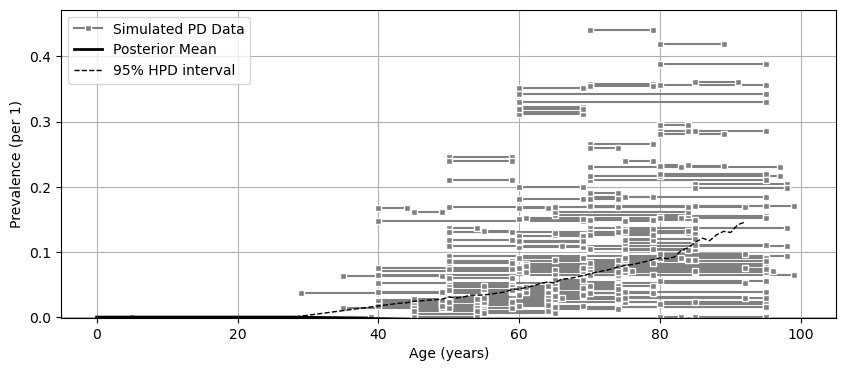

In [256]:
pipeline.visualize_pred(pred, pm_model.shared_data["data"])

In [ ]:
# Execute above cells